# KNN implementation (without using scikit-learn) using Cross Nested Validation. 

## This is an implementation of the K-Nearest Neighbours algorithm, handmade and with an evaluator, that assesses the total accuracy and precision of the model. 

## 1. Exploratory Data Analysis

Using the wine dataset from sklearn library, we will develop a KNN algorithm. This dataset has 13 features, but only 4 are selected in order to keep the code as simple as possible, but without losing a general purpose. 

In [16]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target


### Visualising the data

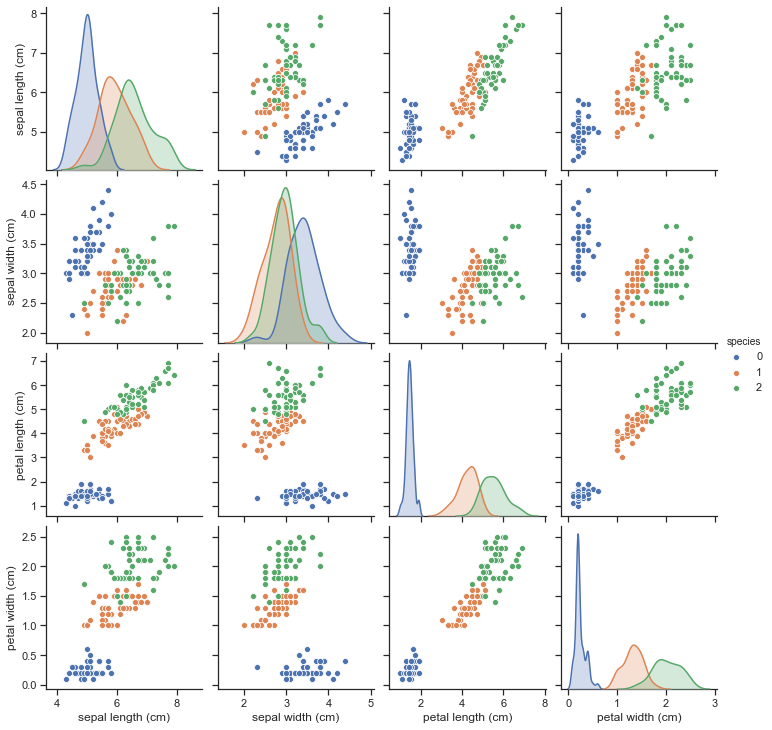

In [17]:
# define plotting function
from pandas.plotting import scatter_matrix

def myPlot(X: np.ndarray, y: np.ndarray):
    df = pd.DataFrame(data=X)
    colors = list()
    colorMap = {0: 'red', 1: 'blue', 2: 'green'}
    for val in y:
        colors.append(colorMap[val])

    scatter_matrix(df, alpha=0.8, diagonal='hist', c=colors, figsize=(10,10))

        

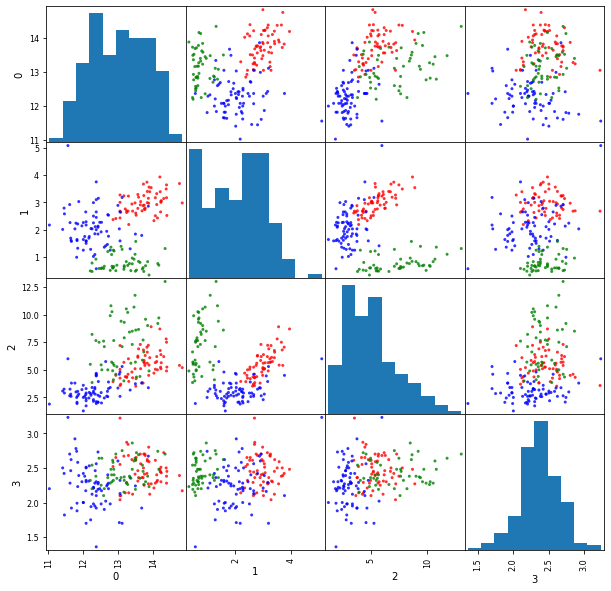

In [29]:
# run the plotting function
myPlot(X,y)


### 1.2. Exploratory Data Analysis under noise

We can add some noise in order to see how our model performs under a more realistic situation where data may not come totally perfect from the source

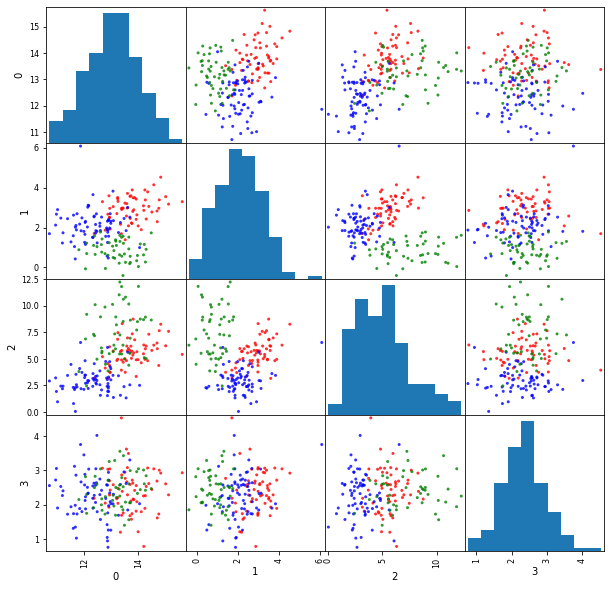

In [19]:
# noise code 


mySeed = 123
np.random.seed(mySeed)
XN = X + np.random.normal(0, 0.5, X.shape)

myPlot(XN, y)



## Code strucutre

First, a definition of an enum, in order to use only three types of distances is declared. This enum consists of a list of constants, EUCLIDEAN, MANHATTAN and CHEBYSHEV. There are the three distances used in the model. 

This is done as a helper for users of the model since it is useful to know what values are allowed, instead of typing 'minkowski' without knowing that it is not a valid distance measure. 

Then, the `split_test_train` method is used in order to split the data into two different sets: the test set, and the train set. The method has been developed to resemble the scikit learn one when calling and applying it to a given dataset. 



In [20]:
# helper code
import math
from enum import Enum


class Distance(Enum):
    EUCLIDEAN = 1
    MANHATTAN = 2
    CHEBYSEV = 3
    

def split_test_train(X,y, test_size=0.25):
    
    L = list(range(X.shape[0]))
    indices = np.random.permutation(L)
    length = len(L)

    # Compute the length of the test and train splits
    test = math.floor(test_size*length)
    train = length - test
    
    # Split
    testIndexes = indices[0:test]
    complementaryIndexes = indices[-train:]

    X_train = X[complementaryIndexes]
    y_train = y[complementaryIndexes]
    X_test = X[testIndexes]
    y_test = y[testIndexes]
        
       
    return X_train, X_test, y_train, y_test




## myKNNclassifier

This class is the main class to classify the data with the KNN model. As with the `split_test_train` method, the `myKNNclassifier` class has been developed to resemble the scikit-learn one. In order to use it, one has to declare a new instance of the class, with two parameters:

* Neighbours
* Metric

It is clear that neighbours is the number of neighbours used in the model, and the metric is the type of distance used to measure the distance between the points of the dataset.

### `fit` method

This method takes as input the train dataset, along with the test features and outputs the predicted labels for these test features. 

In [21]:
# mykNN code
class myKNNclassifier():

    def __init__(self, neighbours: int = 5, metric: Distance = Distance.EUCLIDEAN):
        self.neighbours = neighbours
        self.metric = metric

    def compute_distance(self, v1: np.ndarray, v2: np.ndarray): 
        assert v1.size == v2.size

        if(self.metric == Distance.EUCLIDEAN):
            distances = [ (v1[i] - v2[i])**2 for i in range(v1.size)]
            return math.sqrt(sum(distances))
        if(self.metric == Distance.MANHATTAN):
            distances = [ abs(v1[i] - v2[i]) for i in range(v1.size)]
            return sum(distances)
        if(self.metric == Distance.CHEBYSEV): 
            distances = [ abs( v1[i] - v2[i]) for i in range(v1.size)]
            return max(distances)

    def compute_nearest_neighbours(self, v1: np.ndarray, X: np.ndarray):
        distances = [self.compute_distance(v1, v) for v in X]
        distances = list(enumerate(distances))
        return sorted(distances, key=lambda v: v[1])[:self.neighbours]


    def fit(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray):
        neighbours = []
        predictions = []
        for x in X_test:
            neighbours.append(self.compute_nearest_neighbours(x, X_train))

     
        for i in range(len(X_test)):
            closestPoints =  [v[0] for v in neighbours[i]]
            y_values = list(np.array(y_train)[closestPoints])
            predictions.append(max(set(y_values), key=y_values.count))
        return np.array(predictions)


X_reduced = X
y_reduced = y

X_train, X_test, y_train, y_test = split_test_train(X_reduced, y_reduced)

knn = myKNNclassifier(neighbours=3, metric=Distance.EUCLIDEAN)

y_pred = knn.fit(X_train, y_train, X_test)

print(y_pred)
print(y_test)



[2 1 0 1 1 1 0 1 0 0 0 1 0 2 1 0 1 1 1 1 2 2 0 0 0 1 1 0 0 0 1 1 0 2 1 2 2
 1 0 2 0 2 0 0]
[1 1 0 1 1 1 0 1 0 0 0 1 0 2 1 0 1 1 1 1 2 2 0 0 0 1 1 0 0 0 1 1 0 2 1 2 2
 1 1 2 0 2 0 0]


## `KNNEvaluator` class

To evaluate the KNN model, another class has been developed the `KNNEvaluator` class. An instance of this class will use the predictions, along with the expected values, and the complete label set to output the measures and confusion matrices needed to evaluate the model.

It has 4 methods: 

* `myConfMat`: outputs the confusion matrix of the model.  
* `myAccuracy`: outputs the accuracy of the model. 
* `myPrecision`: outputs the precision of the model, for each label 
* `pretty_print_results` : print the results mentioned above, in a well-formatted way, in order to easily understand the evaluation of the model.

In [22]:
# confusion matrix, accuracy, precision, recall, etc. 

class KNNEvaluator():

    def __init__(self, y_pred: np.array, y_test: np.array, y: np.array):
        self.y_pred = y_pred
        self.y_test = y_test
        self.y = y
        self.all_possible_values = np.unique(y)

    def myConfMat(self) -> np.array:
        """ 
        Build a dictionary to store the indexes of the possible values: 
        Example: 
            possible_values = ['a', 'b', 'c']
            indexesDict = { 'a': 0, 'b': 1, 'c': 2}
        """
        indexes = map(lambda y: [y[1], y[0]], list(enumerate(self.all_possible_values)))
        indexDict = dict(indexes)
        classno = len(self.all_possible_values)
        C = np.array([[0]*classno]*classno)
        for i in range(len(self.y_test)):
            C[indexDict[self.y_test[i]]][indexDict[self.y_pred[i]]] += 1

        return C

    def myAccuracy(self) -> float:
        matrix: np.array = self.myConfMat()
        A = np.sum(np.diagonal(matrix))/len(self.y_test)
        return A 


    def myPrecision(self):
        classes = np.unique(self.y_test)
        guesses = {}
        classCounts = []
        for cl in classes:
            classCounts.append( list(self.y_test).count(cl))
        precision = np.zeros(np.shape(classes))
        aggr = list(zip(self.y_test, self.y_pred))
        for el in aggr:
            if(el[0] == el[1]):
                try:
                    guesses[el[0]] += 1
                except:
                    guesses[el[0]] = 1
        
        for idx, cl in enumerate(classCounts):
            precision[idx] = guesses[idx]/cl

        return precision


    def pretty_print_results(self):
        c = self.myConfMat()
        header = self.all_possible_values
        df = pd.DataFrame(c, columns=[ f'{head}_pred' for head in header])
        df.index.set_names('Real', inplace=True)
        print('------------------------------------')
        print('Confusion matrix of the KNN model: ')
        print(df)
        print('------------------------------------')
        print('Accuracy of the model: ')
        print(self.myAccuracy())
        print('------------------------------------')
        print('Precision of the model: ')
        print(self.myPrecision())
        print('------------------------------------')




In [23]:
# test evaluation code

evaluator = KNNEvaluator(y_pred, y_test, y)

c = evaluator.myConfMat()
a = evaluator.myAccuracy()
evaluator.pretty_print_results()


# Compare the reuslts with the scikit_learn ones. 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


knn_sklearn=KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_sklearn.fit(X_train,y_train)
y_pred_sklearn=knn_sklearn.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,y_pred_sklearn))
print(accuracy_score(y_test,y_pred_sklearn))



------------------------------------
Confusion matrix of the KNN model: 
      0_pred  1_pred  2_pred
Real                        
0         17       0       0
1          1      17       1
2          0       0       8
------------------------------------
Accuracy of the model: 
0.9545454545454546
------------------------------------
Precision of the model: 
[1.         0.89473684 1.        ]
------------------------------------
[[17  0  0]
 [ 1 17  1]
 [ 0  0  8]]
0.9545454545454546



##  Nested Cross-validation using this implementation of KNN 


In [24]:
# parameters for testing code
from itertools import chain
nFolds = 5

def find_best_model(models: list) -> dict:
    best_accuracy = 0
    best_model = None
    for model in models: 
        if model['accuracy'] > best_accuracy:
            best_accuracy = model['accuracy']
            best_model = model
    
    return best_model


# myNestedCrossVal code
from typing import List
def myCrossVal(X: np.ndarray,y: np.ndarray ,nFolds: int, neighboursRange: int, distances: Distance,  mySeed: int) -> dict:
    accuracy_fold=[] #list to store accuracies folds

    for distance in distances:
        assert type(distance) == Distance, f'Distance provided must be of class Distance {[e.name for e in Distance]}'
        
    
    L = list(range(X.shape[0]))
    np.random.seed(mySeed)
    indices=np.random.permutation(L)
    
    #Split the indices into different bins (nFolds)
    bins=np.array_split(indices, nFolds)
    bestModel = {
        'fold' : 0,
        'accuracy' : 0,
        'distance' : None,
        'neighbours' : None,
        'evaluator' : None
    }
    models : List[dict] = []
    accuracies_per_fold = []
    #loop through folds
    for i in range(0,nFolds):
        fold_accuracies = []
        testIndexes: list(int) = bins[i]
        complementaryIndexes = list(chain.from_iterable(list(map(lambda val: list(val) ,np.delete(bins, i)))))
        X_train: np.ndarray = X[complementaryIndexes]
        y_train: np.ndarray = y[complementaryIndexes]
        X_test = X[testIndexes]
        y_test = y[testIndexes]
        for distance in distances:
            for neighbours in range(2,neighboursRange + 1):
                knn = myKNNclassifier(neighbours=neighbours, metric=distance)

                y_pred = knn.fit(X_train, y_train, X_test)
                evaluator: KNNEvaluator = KNNEvaluator(y_pred, y_test, y)
                accuracy_fold.append(evaluator.myAccuracy())
                models.append({
                            'fold' : i,
                            'accuracy' : evaluator.myAccuracy(),
                            'distance' : distance,
                            'neighbours' : neighbours,
                            'evaluator' : evaluator
                        })

                print(f'Fold {i}. Distance {distance.name}, neighbours {neighbours}. Accuracy: {evaluator.myAccuracy()}')

                fold_accuracies.append(evaluator.myAccuracy())
                if(evaluator.myAccuracy() > bestModel['accuracy']):
                    bestModel['fold'] = i
                    bestModel['accuracy']= evaluator.myAccuracy()
                    bestModel['distance'] = distance
                    bestModel['neighbours'] = neighbours
                    bestModel['evaluator'] = evaluator

        # Print accuracy per fold, best set of parameters, and confusion matrix
        print(f'Fold {i}, accuracy: {np.mean(np.array(fold_accuracies))}')
        fold_models = [model for model in models if model['fold'] == i]
        
        best_model = find_best_model(fold_models)
        print(f"Best set of parameters: Distance = {best_model['distance']}. Neighbours = {best_model['neighbours']}")
        print('Confusion matrix: ')
        print(best_model['evaluator'].myConfMat())
        accuracies_per_fold.append(np.mean(np.array(fold_accuracies)))


       
    return [bestModel, models, accuracies_per_fold]


In [25]:
# evaluate clean data code
mySeed = 3
bestModel, results, accuracies = myCrossVal(X, y, 5, 10, [Distance.EUCLIDEAN, Distance.MANHATTAN, Distance.CHEBYSEV], mySeed)
print(bestModel['distance'])
print(bestModel['neighbours'])
bestModel['evaluator'].pretty_print_results()

Fold 0. Distance EUCLIDEAN, neighbours 2. Accuracy: 0.8333333333333334
Fold 0. Distance EUCLIDEAN, neighbours 3. Accuracy: 0.8888888888888888
Fold 0. Distance EUCLIDEAN, neighbours 4. Accuracy: 0.9166666666666666
Fold 0. Distance EUCLIDEAN, neighbours 5. Accuracy: 0.9166666666666666
Fold 0. Distance EUCLIDEAN, neighbours 6. Accuracy: 0.8888888888888888
Fold 0. Distance EUCLIDEAN, neighbours 7. Accuracy: 0.9166666666666666
Fold 0. Distance EUCLIDEAN, neighbours 8. Accuracy: 0.8611111111111112
Fold 0. Distance EUCLIDEAN, neighbours 9. Accuracy: 0.8888888888888888
Fold 0. Distance EUCLIDEAN, neighbours 10. Accuracy: 0.8333333333333334
Fold 0. Distance MANHATTAN, neighbours 2. Accuracy: 0.8611111111111112
Fold 0. Distance MANHATTAN, neighbours 3. Accuracy: 0.8888888888888888
Fold 0. Distance MANHATTAN, neighbours 4. Accuracy: 0.8888888888888888
Fold 0. Distance MANHATTAN, neighbours 5. Accuracy: 0.9166666666666666
Fold 0. Distance MANHATTAN, neighbours 6. Accuracy: 0.8888888888888888
Fold 

In [26]:
# evaluate noisy  data code
bestModelN, resultsN, accuraciesN = myCrossVal(XN, y, 5, 10, [Distance.EUCLIDEAN, Distance.MANHATTAN, Distance.CHEBYSEV], mySeed)
print(bestModelN['distance'])
print(bestModelN['neighbours'])
bestModelN['evaluator'].pretty_print_results()

Fold 0. Distance EUCLIDEAN, neighbours 2. Accuracy: 0.8333333333333334
Fold 0. Distance EUCLIDEAN, neighbours 3. Accuracy: 0.8611111111111112
Fold 0. Distance EUCLIDEAN, neighbours 4. Accuracy: 0.8611111111111112
Fold 0. Distance EUCLIDEAN, neighbours 5. Accuracy: 0.8888888888888888
Fold 0. Distance EUCLIDEAN, neighbours 6. Accuracy: 0.8611111111111112
Fold 0. Distance EUCLIDEAN, neighbours 7. Accuracy: 0.8888888888888888
Fold 0. Distance EUCLIDEAN, neighbours 8. Accuracy: 0.8888888888888888
Fold 0. Distance EUCLIDEAN, neighbours 9. Accuracy: 0.8611111111111112
Fold 0. Distance EUCLIDEAN, neighbours 10. Accuracy: 0.8611111111111112
Fold 0. Distance MANHATTAN, neighbours 2. Accuracy: 0.8055555555555556
Fold 0. Distance MANHATTAN, neighbours 3. Accuracy: 0.8611111111111112
Fold 0. Distance MANHATTAN, neighbours 4. Accuracy: 0.8611111111111112
Fold 0. Distance MANHATTAN, neighbours 5. Accuracy: 0.9166666666666666
Fold 0. Distance MANHATTAN, neighbours 6. Accuracy: 0.8888888888888888
Fold 

In [27]:
def get_best_models(results: dict):
    highestAccuracies = [0,0,0,0,0]
    bestFolds = [None, None, None, None, None]
    for result in results: 
        if highestAccuracies[result['fold']] < result['accuracy']:
            bestFolds[result['fold']] = result
            highestAccuracies[result['fold']] = result['accuracy']

    accuracies = [x['accuracy'] for x in bestFolds]
    std = np.std([x['accuracy'] for x in bestFolds])        
    mean = np.mean([x['accuracy'] for x in bestFolds])   

    return [bestFolds, std, mean]

print('Data without noise: ')
print(get_best_models(results))
print('--------------------')
print('Data with noise: ')
print(get_best_models(resultsN))

Data without noise: 
[[{'fold': 0, 'accuracy': 0.9166666666666666, 'distance': <Distance.EUCLIDEAN: 1>, 'neighbours': 4, 'evaluator': <__main__.KNNEvaluator object at 0x7fc0942bb050>}, {'fold': 1, 'accuracy': 0.9722222222222222, 'distance': <Distance.EUCLIDEAN: 1>, 'neighbours': 2, 'evaluator': <__main__.KNNEvaluator object at 0x7fc093bc9d10>}, {'fold': 2, 'accuracy': 0.9444444444444444, 'distance': <Distance.EUCLIDEAN: 1>, 'neighbours': 3, 'evaluator': <__main__.KNNEvaluator object at 0x7fc094327510>}, {'fold': 3, 'accuracy': 0.9714285714285714, 'distance': <Distance.EUCLIDEAN: 1>, 'neighbours': 2, 'evaluator': <__main__.KNNEvaluator object at 0x7fc09438ab50>}, {'fold': 4, 'accuracy': 0.9428571428571428, 'distance': <Distance.EUCLIDEAN: 1>, 'neighbours': 3, 'evaluator': <__main__.KNNEvaluator object at 0x7fc094395f90>}], 0.020711700866516903, 0.9495238095238095]
--------------------
Data with noise: 
[[{'fold': 0, 'accuracy': 0.9166666666666666, 'distance': <Distance.MANHATTAN: 2>, 'n

## Summary of results 

Clean data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .916  |  4 | euclidean |
| 2 | .972  |  2 | euclidean  |
| 3 | .944  |  3 | euclidean  |
| 4 | .971  |  2 | euclidean  |
| 5 | .943  |  3 | euclidean  |
| **total** | .949 $\pm$ 0.0207 |   |    |


Noisy data: 

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | .916  |  5 | Manhattan  |
| 2 | .944  |  3 | Euclidean  |
| 3 | .944  |  6 | Manhattan  |
| 4 | .9428  |  10 | Euclidean  |
| 5 | .9428  |  4 | Euclidean  |
| **total** | .938 $\pm$ 0.0108 |   |    |


### Confusion Matrix summary


For the definition of the summary confusion matrix, what has been done is a mean of all the terms of all the confusion matrices obtained from the clean results and the noisy results. 

In [28]:
print('CLEAN')

def build_summary_conf_mat(results: List[KNNEvaluator]):
     summaryMat = np.ndarray(shape=results[0]['evaluator'].myConfMat().shape)
     mean_conf_mat = np.mean([result['evaluator'].myConfMat() for result in results], axis=0)
     dataframe = pd.DataFrame(data=mean_conf_mat, columns=['0_pred', '1_pred', '2_pred'])
     dataframe.index.set_names('REAL', inplace=True)
     return dataframe


         

print(build_summary_conf_mat(results))


print('NOISY')
print(build_summary_conf_mat(resultsN))


CLEAN
         0_pred     1_pred    2_pred
REAL                                
0     11.770370   0.029630  0.000000
1      1.962963  11.896296  0.340741
2      0.000000   0.318519  9.281481
NOISY
         0_pred     1_pred    2_pred
REAL                                
0     10.481481   1.281481  0.037037
1      1.140741  12.800000  0.259259
2      0.185185   0.562963  8.851852
